In [24]:
import pandas as pd
import glob

# Load all round 1 and 2 CSVs and annotate with round info
csv_files = glob.glob("data/prices_round_[127]_day_*.csv")
squid_dataframes = []

for file in csv_files:
    round_number = int(file.split("round_")[1].split("_")[0])
    df = pd.read_csv(file, sep=";")
    squid_df = df[df["product"] == "SQUID_INK"].copy()
    squid_df["round"] = round_number
    squid_dataframes.append(squid_df)

# Combine and save
squid_combined = pd.concat(squid_dataframes, ignore_index=True)
squid_output_path = "data/squid_ink_only.csv"
squid_combined.to_csv(squid_output_path, index=False)

squid_output_path


'data/squid_ink_only.csv'

In [21]:
squid_combined["mid_price"].mean(), squid_combined["mid_price"].std()



(1924.95084375, 70.23916397594799)

In [26]:
import numpy as np
import pandas as pd

# Assuming df is already loaded
# Compute true (global) mean and std
true_mean = df["mid_price"].mean()
true_std = df["mid_price"].std()

def get_popular_bid_ask(row):
    bids = [(row[f"bid_price_{i}"], row[f"bid_volume_{i}"]) for i in range(1, 4) if not pd.isna(row[f"bid_price_{i}"])]
    asks = [(row[f"ask_price_{i}"], row[f"ask_volume_{i}"]) for i in range(1, 4) if not pd.isna(row[f"ask_price_{i}"])]

    popular_bid = max(bids, key=lambda x: x[1])[0] if bids else np.nan
    popular_ask = max(asks, key=lambda x: x[1])[0] if asks else np.nan

    return pd.Series([popular_bid, popular_ask], index=["popular_bid", "popular_ask"])

df[["popular_bid", "popular_ask"]] = df.apply(get_popular_bid_ask, axis=1)

# Calculate z-score
df["z_score"] = (df["mid_price"] - true_mean) / true_std

entry_z_range = np.linspace(0.5, 2.0, 11)
exit_z_range = np.linspace(0.1, 1.1, 11)

results = []

# Grid search using true mean and std
for entry_z in entry_z_range:
    for exit_z in exit_z_range:
        if exit_z >= entry_z:  # Skip invalid combinations
            continue
        
        position = 0
        cash = 0
        pnl_list = []
        
        # Track positions and their entry prices
        entry_price = 0
        trades = 0
        winning_trades = 0
        
        for idx, row in df.iterrows():
            z = row["z_score"]
            price_to_buy = row["popular_ask"]
            price_to_sell = row["popular_bid"]

            if pd.isna(price_to_buy) or pd.isna(price_to_sell):
                current_mid = row["mid_price"] if not pd.isna(row["mid_price"]) else (pnl_list[-1] if pnl_list else 0)
                mark_to_market = cash + (position * current_mid)
                pnl_list.append(mark_to_market)
                continue

            # === ENTRY ===
            if position == 0:
                if z < -entry_z:  # Price is low, buy
                    position = 1
                    cash -= price_to_buy
                    entry_price = price_to_buy
                elif z > entry_z:  # Price is high, sell
                    position = -1
                    cash += price_to_sell
                    entry_price = price_to_sell

            # === EXIT ===
            elif position == 1 and z > -exit_z:  # Exit long position
                cash += price_to_sell
                trades += 1
                if price_to_sell > entry_price:
                    winning_trades += 1
                position = 0
            elif position == -1 and z < exit_z:  # Exit short position
                cash -= price_to_buy
                trades += 1
                if price_to_buy < entry_price:
                    winning_trades += 1
                position = 0

            # Mark-to-market PnL
            mark_to_market = cash
            if position == 1:
                mark_to_market += row["mid_price"]  # Value of our long position
            elif position == -1:
                mark_to_market -= row["mid_price"]  # Cost to cover our short position
                
            pnl_list.append(mark_to_market)

        # Close any open position at the end using the last available price
        final_row = df.iloc[-1]
        if position == 1:
            cash += final_row["popular_bid"]  # Sell at bid
            trades += 1
            if final_row["popular_bid"] > entry_price:
                winning_trades += 1
        elif position == -1:
            cash -= final_row["popular_ask"]  # Buy at ask
            trades += 1
            if final_row["popular_ask"] < entry_price:
                winning_trades += 1

        final_pnl = cash
        win_rate = winning_trades / max(1, trades)  # Avoid division by zero
        
        # Calculate Sharpe ratio safely
        pnl_array = np.array(pnl_list)
        if len(pnl_array) > 1:
            daily_returns = np.diff(pnl_array)
            # Avoid division by zero when calculating percentage returns
            daily_returns_pct = np.zeros(len(daily_returns))
            for i in range(len(daily_returns)):
                if abs(pnl_array[i]) > 1e-10:  # Threshold to avoid near-zero division
                    daily_returns_pct[i] = daily_returns[i] / abs(pnl_array[i])
            
            # Remove NaN values
            daily_returns_pct = daily_returns_pct[~np.isnan(daily_returns_pct)]
            
            # Calculate Sharpe ratio safely
            if len(daily_returns_pct) > 0 and np.std(daily_returns_pct) > 1e-10:
                sharpe = np.mean(daily_returns_pct) / np.std(daily_returns_pct) * np.sqrt(252)
            else:
                sharpe = 0
        else:
            sharpe = 0
        
        results.append((entry_z, exit_z, final_pnl, trades, win_rate, sharpe))

# Save results
results_df = pd.DataFrame(results, columns=["entry_z", "exit_z", "pnl", "trades", "win_rate", "sharpe"])
results_df = results_df.sort_values("pnl", ascending=False)  # Sort by PnL instead of potentially unstable Sharpe
results_df.to_csv("./data/mean_reversion_fixed.csv", index=False)

print(f"Best parameters: Entry Z={results_df.iloc[0]['entry_z']:.2f}, Exit Z={results_df.iloc[0]['exit_z']:.2f}")
print(f"PnL: {results_df.iloc[0]['pnl']:.2f}, Trades: {results_df.iloc[0]['trades']}, Win Rate: {results_df.iloc[0]['win_rate']:.2%}")
print(f"Sharpe Ratio: {results_df.iloc[0]['sharpe']:.2f}")

# Plot PnL over time for best strategy
best_entry_z = results_df.iloc[0]['entry_z']
best_exit_z = results_df.iloc[0]['exit_z']

# Re-run the best strategy to get the PnL curve
position = 0
cash = 0
pnl_list = []
position_list = []
entry_price = 0

for idx, row in df.iterrows():
    z = row["z_score"]
    price_to_buy = row["popular_ask"]
    price_to_sell = row["popular_bid"]

    if pd.isna(price_to_buy) or pd.isna(price_to_sell):
        if len(pnl_list) > 0:
            pnl_list.append(pnl_list[-1])
        else:
            pnl_list.append(0)
        position_list.append(position)
        continue

    # === ENTRY ===
    if position == 0:
        if z < -best_entry_z:
            position = 1
            cash -= price_to_buy
            entry_price = price_to_buy
        elif z > best_entry_z:
            position = -1
            cash += price_to_sell
            entry_price = price_to_sell

    # === EXIT ===
    elif position == 1 and z > -best_exit_z:
        cash += price_to_sell
        position = 0
    elif position == -1 and z < best_exit_z:
        cash -= price_to_buy
        position = 0

    # Mark-to-market PnL
    mark_to_market = cash
    if position == 1:
        mark_to_market += row["mid_price"]
    elif position == -1:
        mark_to_market -= row["mid_price"]
        
    pnl_list.append(mark_to_market)
    position_list.append(position)

# Add results to DataFrame for visualization
df['best_strategy_pnl'] = pd.Series(pnl_list, index=df.index[:len(pnl_list)])
df['position'] = pd.Series(position_list, index=df.index[:len(position_list)])

# Display summary statistics
print("\nStrategy Performance Summary:")
print(f"Total PnL: {pnl_list[-1]:.2f}")

# Calculate max drawdown safely
if len(pnl_list) > 0:
    cummax = np.maximum.accumulate(pnl_list)
    drawdown = cummax - pnl_list
    if np.max(cummax) > 0:
        max_dd_pct = np.max(drawdown) / np.max(cummax)
    else:
        max_dd_pct = 0
    print(f"Max Drawdown: {max_dd_pct:.2%}")

Best parameters: Entry Z=0.50, Exit Z=0.10
PnL: 80316860.00, Trades: 10001.0, Win Rate: 99.99%
Sharpe Ratio: 0.09

Strategy Performance Summary:
Total PnL: 80316861.50
Max Drawdown: 0.00%


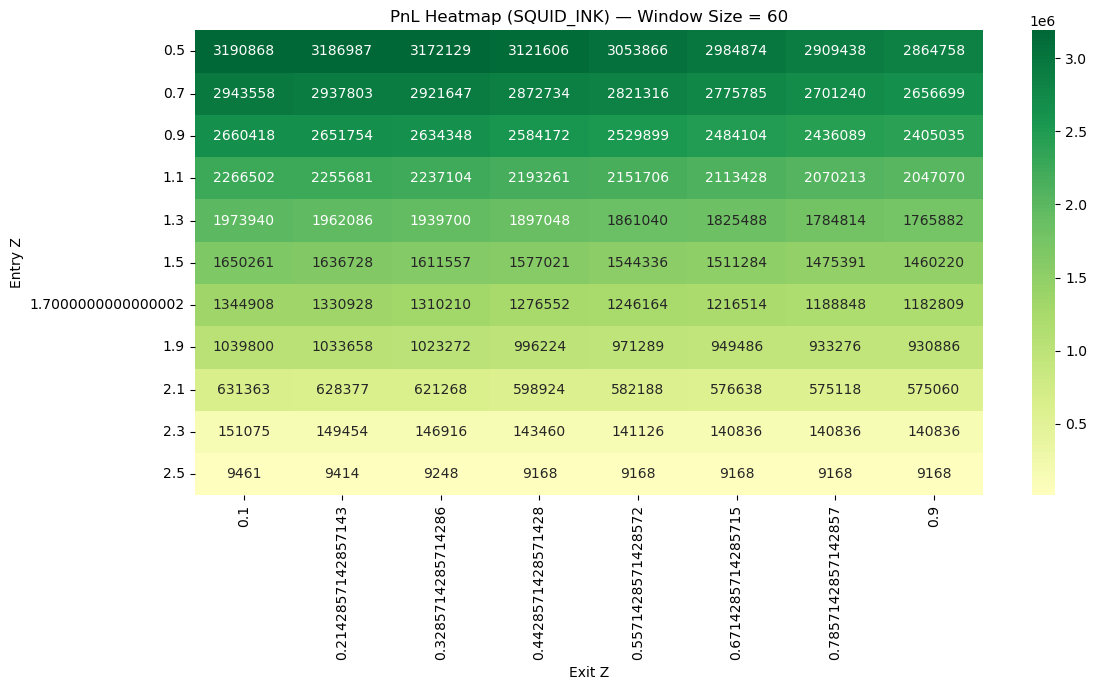

,Unnamed: 0,window,entry_z,exit_z,pnl
0,704,100,0.5,0.100000,3193887.0
1,616,80,0.5,0.100000,3192754.0
2,705,100,0.5,0.214286,3192691.0
3,617,80,0.5,0.214286,3192009.0
4,528,60,0.5,0.100000,3190867.5
5,529,60,0.5,0.214286,3186987.0
6,706,100,0.5,0.328571,3179287.5
7,440,40,0.5,0.100000,3178535.5
8,618,80,0.5,0.328571,3177717.5
9,441,40,0.5,0.214286,3173855.5


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the uploaded results CSV
results_df = pd.read_csv("./data/mean_reversion_squid.csv")

# Get top 25 best performing parameter sets
top25 = results_df.sort_values("pnl", ascending=False).head(25)

# Choose the most frequent best-performing window
best_window = top25["window"].mode()[0]
subset = results_df[results_df["window"] == best_window]

# Pivot for heatmap (entry_z vs exit_z)
heatmap_data = subset.pivot(index="entry_z", columns="exit_z", values="pnl")

# Plot heatmap
plt.figure(figsize=(12, 7))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="RdYlGn", center=0)
plt.title(f"PnL Heatmap (SQUID_INK) — Window Size = {best_window}")
plt.xlabel("Exit Z")
plt.ylabel("Entry Z")
plt.tight_layout()
plt.show()

# Return the top 10 parameter sets
top10 = top25.reset_index(drop=True).head(10)
top10


In [ ]:
import pandas as pd
import numpy as np

# Load and prepare data
df = pd.read_csv("data/squid_ink_only.csv").sort_values("timestamp").reset_index(drop=True)
df["mid_price"] = pd.to_numeric(df["mid_price"], errors="coerce")
df = df.dropna(subset=["mid_price"])

true_mean = 1924.95084375
true_std = 70.23916397594667
position_limit = 50

def get_best_bid_ask(row):
    bids = [row[f"bid_price_{i}"] for i in range(1, 4) if not pd.isna(row[f"bid_price_{i}"])]
    asks = [row[f"ask_price_{i}"] for i in range(1, 4) if not pd.isna(row[f"ask_price_{i}"])]
    return pd.Series([max(bids) if bids else np.nan, min(asks) if asks else np.nan], index=["best_bid", "best_ask"])

df[["best_bid", "best_ask"]] = df.apply(get_best_bid_ask, axis=1)
df["z_score"] = (df["mid_price"] - true_mean) / true_std

# Parameter grid
z_threshold_values = np.linspace(0.1, 1.5, 1)
max_z_values = [1.5]
results = []

for z_thresh in z_threshold_values:
    for max_z in max_z_values:
        position = 0
        cash = 0

        for _, row in df.iterrows():
            z = row["z_score"]
            best_bid = row["best_bid"]
            best_ask = row["best_ask"]

            if pd.isna(best_bid) or pd.isna(best_ask):
                continue

            def scale_qty(z_val):
                return int((min(abs(z_val), max_z) / max_z) * position_limit)

            if z > z_thresh:
                target = -scale_qty(z)
            elif z < -z_thresh:
                target = scale_qty(z)
            else:
                target = position  # no change

            delta = target - position
            if delta > 0:
                # Buy
                position += delta
                cash -= best_ask * delta
            elif delta < 0:
                # Sell
                position += delta
                cash += best_bid * (-delta)


        final_price = df.iloc[-1]["mid_price"]
        final_pnl = cash + position * final_price
        results.append((z_thresh, max_z, final_pnl))

# Save results
results_df = pd.DataFrame(results, columns=["z_threshold", "max_z", "pnl"])
results_df = results_df.sort_values("pnl", ascending=False).reset_index(drop=True)
results_df.to_csv("squidink_unified_z_optimization.csv", index=False)


KeyError: -1

In [50]:
import pandas as pd

# Load your saved parameter grid results
results_df = pd.read_csv("squidink_unified_z_optimization.csv")

# Sort by PnL descending to find the best parameter sets
top_25 = results_df.sort_values("pnl", ascending=False).head(25).reset_index(drop=True)

# Display top 25 combinations
print(top_25)

# Find the best combo
best = top_25.iloc[0]
print("\n🔍 Best Performing Parameters:")
print(f"Best Z:   {best['z_threshold']:.2f}")
print(f"Max Z:   {best['max_z']:.2f}")
print(f"PNL:     {best['pnl']:.2f}")


    z_threshold  max_z          pnl
0           0.1    2.0  123916588.0
1           0.1    2.1  121285128.0
2           0.2    2.0  118801146.0
3           0.1    2.2  118564497.0
4           0.2    2.1  116323381.0
5           0.1    2.3  115632507.5
6           0.2    2.2  113766721.0
7           0.3    2.0  112800256.0
8           0.1    2.4  112481611.5
9           0.2    2.3  110990697.5
10          0.3    2.1  110530685.0
11          0.1    2.5  109306063.5
12          0.3    2.2  108187080.0
13          0.2    2.4  108001954.5
14          0.4    2.0  107111679.0
15          0.1    2.6  106084707.5
16          0.3    2.3  105619911.5
17          0.4    2.1  105037833.0
18          0.2    2.5  104971249.5
19          0.1    2.7  102928429.0
20          0.4    2.2  102884461.0
21          0.3    2.4  102830002.5
22          0.2    2.6  101901744.5
23          0.5    2.0  100627161.0
24          0.4    2.3  100516926.5

🔍 Best Performing Parameters:
Best Z:   0.10
Max Z:   2.00
PNL:

In [29]:
# Get true mean and std
true_mean = df["mid_price"].mean()
true_std = df["mid_price"].std()

true_mean, true_std 

(1924.95084375, 70.23916397594667)